In [1]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

import glob
from pandas.tseries.offsets import *

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


## Rng strategies

In [ ]:
#
# random time series
#
df = pd.DataFrame()
for i in range(100):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

## Select input DF. Real swarms or RNG pseudo strategies

In [3]:
# Real swarms
#df = campaign_portfolio

# Rng strategies
#df = df

# Real swarms from csv
#df = pd.read_csv('./swarms_df/ma_cross_swarm_new.csv', parse_dates=[0],
#                dayfirst=True, index_col=0).asfreq(BDay())

# set file name here
swarm_file = 'EP_BearishCollarBrokenWing_Short_BollingerBands'

# Real swarm from .swm
df = Swarm.load('./temp_swarms/'+swarm_file+'.swm')
df = df.raw_swarm

In [ ]:
df = pd.DataFrame()

for file in glob.glob("./portfolios/*.csv"):
    
    portfolio_df = pd.read_csv(file, dayfirst=True, index_col=[0], parse_dates=[0], names=['date', file.split('\\')[1].split('.')[0]])
    portfolio_df = portfolio_df.groupby(portfolio_df.index).last().asfreq(BDay())
    
    #portfolio_df.columns[0] = file.split('\\')[1].split('.')[0]
    
    if len(df) == 0:
        df = portfolio_df
    else:
        df = pd.concat([df, portfolio_df],axis=1)
        
df = df.ffill().fillna(0.0)

In [ ]:
all_equities_sum = df.sum(axis=1)

In [ ]:
swarm = SwarmManager.load('./temp_swarms/'+swarm_file+'.swm')

## Systems overall performance estimation

In [4]:
temp_l = []

for strat in df.columns:

        input_strategy_data = df[strat] # This data is used in metrics calc

        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan

        d = {'strategy': strat,
            'stats_pricechange_modsharpe': modsharpe, 
            'stats_netprofit': netprofit,
            'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
            'stats_profit_factor': profit_factor, 'stats_winrate': winrate }

        temp_l.append(d)

In [5]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rank_score'] = np.zeros_like(len(strategies_performance_df))

In [6]:
strategies_performance_df

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
0,-16294.5,2380.5,0.004122,1.021000,0.146092,22.819767,"(-1, 10, 2, 15, 1)",0
1,-13021.5,-5287.0,-0.007946,0.964975,-0.406021,29.433140,"(-1, 10, 2, 15, 10)",0
2,-13560.5,-3664.5,-0.005587,0.975312,-0.270233,29.505814,"(-1, 10, 2, 15, 11)",0
3,-14185.0,-2893.0,-0.004331,0.980874,-0.203948,29.869186,"(-1, 10, 2, 15, 12)",0
4,-16478.5,-5360.0,-0.007985,0.965972,-0.325272,31.250000,"(-1, 10, 2, 15, 13)",0
5,-14460.0,-2924.5,-0.004516,0.980071,-0.202248,30.377907,"(-1, 10, 2, 15, 14)",0
6,-14460.0,-2373.5,-0.003665,0.983859,-0.164142,30.668605,"(-1, 10, 2, 15, 15)",0
7,-16901.5,-2773.5,-0.004260,0.981213,-0.164098,30.741279,"(-1, 10, 2, 15, 16)",0
8,-16315.0,-2824.0,-0.004192,0.982138,-0.173092,31.976744,"(-1, 10, 2, 15, 17)",0
9,-16382.5,-2249.0,-0.003335,0.985795,-0.137281,32.049419,"(-1, 10, 2, 15, 18)",0


## Strategies overall performance ranking

In [7]:
ranks_d = {}

for col in strategies_performance_df.columns:
    
    stats_col_flag = False
    
    if 'stats' in col:

        # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
        metric_quantile0 = strategies_performance_df[col].quantile(0.0)
        metric_quantile10 = strategies_performance_df[col].quantile(0.1)
        metric_quantile20 = strategies_performance_df[col].quantile(0.2)
        metric_quantile30 = strategies_performance_df[col].quantile(0.3)
        metric_quantile40 = strategies_performance_df[col].quantile(0.4)
        metric_quantile50 = strategies_performance_df[col].quantile(0.5)
        metric_quantile60 = strategies_performance_df[col].quantile(0.6)
        metric_quantile70 = strategies_performance_df[col].quantile(0.7)
        metric_quantile80 = strategies_performance_df[col].quantile(0.8)
        metric_quantile90 = strategies_performance_df[col].quantile(0.9)
        metric_quantile100 = strategies_performance_df[col].quantile(1)
        
        stats_col_flag = True
    
    if stats_col_flag == True:
        
        for strat in strategies_performance_df.strategy:
        
            # Define strategy statistics rank of certain strategy

            strategy_stats_metric = strategies_performance_df[strategies_performance_df.strategy == strat][col].values[0]

            if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                rank_score = 0

            elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                rank_score = 1

            elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                rank_score = 2

            elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                rank_score = 3

            elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                rank_score = 4

            elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                rank_score = 5

            elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                rank_score = 6

            elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                rank_score = 7

            elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                rank_score = 8

            elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                rank_score = 9

            elif strategy_stats_metric == metric_quantile100:
                rank_score = 10

                
            if strat not in ranks_d.keys():               
                ranks_d[strat] = rank_score
                
            elif strat in ranks_d.keys():                
                ranks_d[strat] = ranks_d[strat] + rank_score
                          
            # For debugging purposes

            #print('strategy---',strat,'\n')
            #print(col)
            #print('10 quantile---',metric_quantile10)
            #print(strategy_stats_metric)
            #print('60 quantile---',metric_quantile60)
            #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
            #print('rank_score------', rank_score, '\n')

        #print("NEXT----------------------- \n")

# Set rank scores for strategies from dict

for k in ranks_d:
    
    strat_index = strategies_performance_df[strategies_performance_df.strategy == k].index
    strategies_performance_df = strategies_performance_df.set_value(strat_index, 'rank_score', ranks_d[k])

In [8]:
strategies_performance_df.sort_values('rank_score', ascending=False)

,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
428,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 10, 3, 25, 17)",49
2628,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 30, 5, 25, 17)",49
1748,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 20, 5, 25, 17)",49
2188,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 30, 3, 25, 17)",49
1308,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 20, 3, 25, 17)",49
2408,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 30, 4, 25, 17)",49
208,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 10, 2, 25, 17)",49
648,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 10, 4, 25, 17)",49
1088,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 20, 2, 25, 17)",49
868,-7051.5,42751.0,0.072088,1.430181,6.062682,24.927326,"(-1, 10, 5, 25, 17)",49


## Drop all strategies which have rank score less than n quantile value 

In [9]:
df = df[strategies_performance_df[strategies_performance_df.rank_score >= strategies_performance_df.rank_score.quantile(0.0)].strategy]

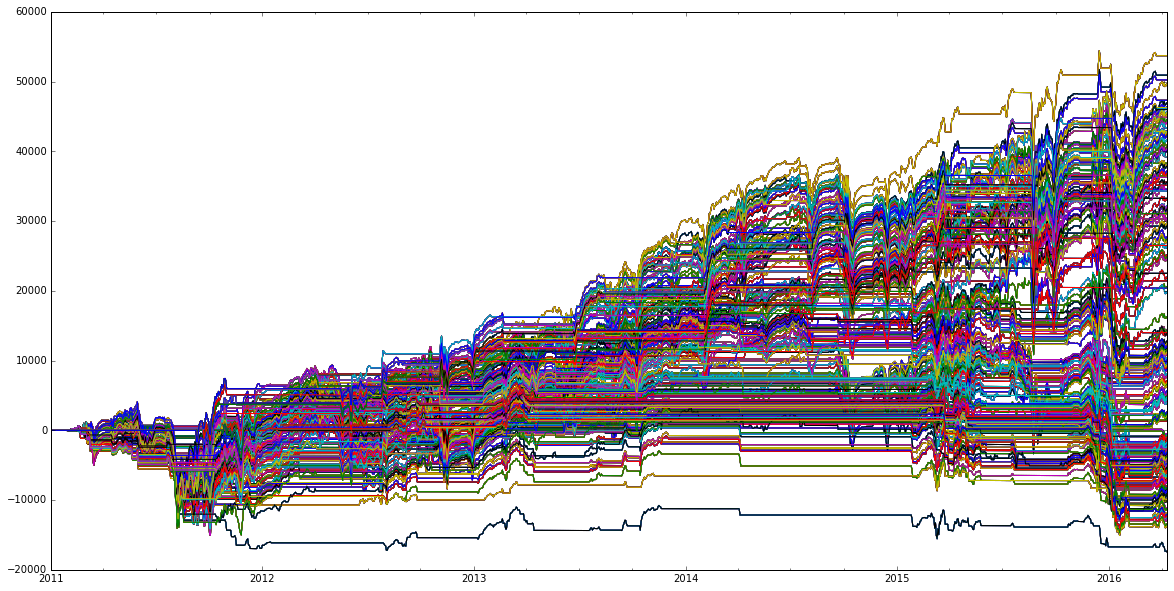

In [10]:
df.dropna().plot(legend=False)

## Filter those strategies by correlation

In [11]:
# Rearrange columns from best to worst strategies
df = df.reindex_axis(strategies_performance_df.sort_values('rank_score', ascending=False).strategy, axis=1).dropna(axis=1).asfreq(BDay())

In [12]:
df.corr()

strategy,"(-1, 10, 3, 25, 17)","(-1, 30, 5, 25, 17)","(-1, 20, 5, 25, 17)","(-1, 30, 3, 25, 17)","(-1, 20, 3, 25, 17)","(-1, 30, 4, 25, 17)","(-1, 10, 2, 25, 17)","(-1, 10, 4, 25, 17)","(-1, 20, 2, 25, 17)","(-1, 10, 5, 25, 17)",...,"(-1, 20, 3, 23, 7)","(-1, 20, 3, 23, 6)","(-1, 20, 3, 23, 5)","(-1, 20, 3, 23, 4)","(-1, 20, 3, 23, 3)","(-1, 10, 3, 23, 6)","(-1, 10, 3, 23, 7)","(-1, 10, 3, 23, 8)","(-1, 30, 4, 23, 3)","(-1, 10, 2, 23, 6)"
strategy,,,,,,,,,,,,,,,,,,,,,
"(-1, 10, 3, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636
"(-1, 30, 5, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636
"(-1, 20, 5, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636
"(-1, 30, 3, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636
"(-1, 20, 3, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636
"(-1, 30, 4, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636
"(-1, 10, 2, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636
"(-1, 10, 4, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636
"(-1, 20, 2, 25, 17)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.207633,-0.207636,-0.359935,-0.269570,-0.191920,-0.207636,-0.207633,-0.369751,-0.191920,-0.207636


In [13]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [14]:
df.corr()

strategy,"(-1, 10, 3, 25, 17)","(-1, 30, 4, 22, 17)","(-1, 20, 2, 17, 10)","(-1, 20, 3, 16, 6)","(-1, 30, 2, 23, 2)"
strategy,,,,,
"(-1, 10, 3, 25, 17)",1.000000,0.487776,0.362490,-0.342101,-0.300090
"(-1, 30, 4, 22, 17)",0.487776,1.000000,0.461972,-0.281053,0.423300
"(-1, 20, 2, 17, 10)",0.362490,0.461972,1.000000,0.457790,0.397562
"(-1, 20, 3, 16, 6)",-0.342101,-0.281053,0.457790,1.000000,0.198159
"(-1, 30, 2, 23, 2)",-0.300090,0.423300,0.397562,0.198159,1.000000


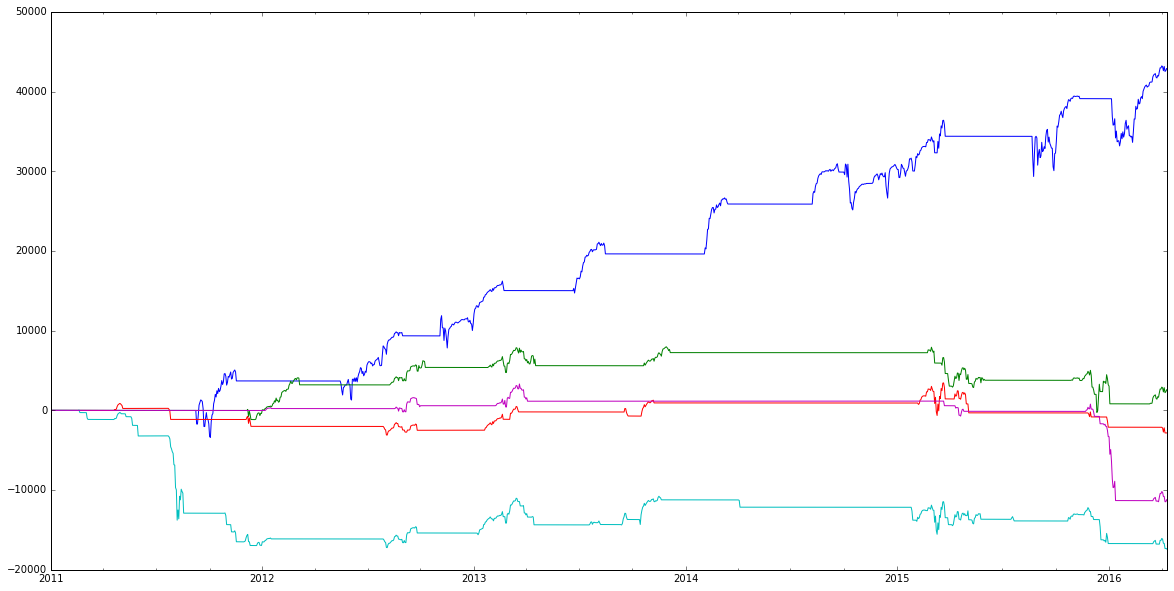

In [15]:
df.dropna().plot(legend=False)

# Metrics calculation

In [16]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate, 
                     'equity_below_zero': df[strat].ix[rebalance_date_start] < 0}
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [17]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [18]:
stats_df.tail(10)

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
1370,False,2016-04-04,2016-03-28,275,-92.5,1185.0,0.920807,12.560976,12.810811,60.000000,"(-1, 10, 3, 25, 17)"
1371,False,2016-04-04,2016-03-28,275,-92.5,1185.0,0.920807,12.560976,12.810811,60.000000,"(-1, 30, 4, 22, 17)"
1372,True,2016-04-04,2016-03-28,275,-104.5,-104.5,-0.578941,0.000001,-1.000000,0.000001,"(-1, 20, 2, 17, 10)"
1373,True,2016-04-04,2016-03-28,275,-92.5,610.5,0.580415,6.331878,6.600000,40.000000,"(-1, 20, 3, 16, 6)"
1374,True,2016-04-04,2016-03-28,275,-92.5,1185.0,0.920807,12.560976,12.810811,60.000000,"(-1, 30, 2, 23, 2)"
1375,False,2016-04-11,2016-04-04,276,-630.0,-222.5,-0.098793,0.804396,-0.353175,60.000000,"(-1, 10, 3, 25, 17)"
1376,False,2016-04-11,2016-04-04,276,-630.0,-222.5,-0.098793,0.804396,-0.353175,60.000000,"(-1, 30, 4, 22, 17)"
1377,True,2016-04-11,2016-04-04,276,-642.0,-617.0,-0.294623,0.463245,-0.961059,20.000000,"(-1, 20, 2, 17, 10)"
1378,True,2016-04-11,2016-04-04,276,-1185.5,-1185.5,-0.836968,0.000001,-1.000000,0.000001,"(-1, 20, 3, 16, 6)"
1379,True,2016-04-11,2016-04-04,276,-1185.5,-913.0,-0.531626,0.229861,-0.770139,20.000000,"(-1, 30, 2, 23, 2)"


## Statistics rank calculation

In [19]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 8
rebalance index --- 9
rebalance index --- 10
rebalance index --- 11
rebalance index --- 12
rebalance index --- 13
rebalance index --- 14
rebalance index --- 15
rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index --- 45
rebalance index --- 46
rebalance index --- 47
rebalance index --- 48
rebalance index --- 49
rebalance index --- 50
rebalance ind

In [20]:
stats_df.tail(10)

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
1370,False,2016-04-04,2016-03-28,275,-92.5,1185.0,0.920807,12.560976,12.810811,60.000000,"(-1, 10, 3, 25, 17)",44.0
1371,False,2016-04-04,2016-03-28,275,-92.5,1185.0,0.920807,12.560976,12.810811,60.000000,"(-1, 30, 4, 22, 17)",44.0
1372,True,2016-04-04,2016-03-28,275,-104.5,-104.5,-0.578941,0.000001,-1.000000,0.000001,"(-1, 20, 2, 17, 10)",17.0
1373,True,2016-04-04,2016-03-28,275,-92.5,610.5,0.580415,6.331878,6.600000,40.000000,"(-1, 20, 3, 16, 6)",34.0
1374,True,2016-04-04,2016-03-28,275,-92.5,1185.0,0.920807,12.560976,12.810811,60.000000,"(-1, 30, 2, 23, 2)",35.0
1375,False,2016-04-11,2016-04-04,276,-630.0,-222.5,-0.098793,0.804396,-0.353175,60.000000,"(-1, 10, 3, 25, 17)",39.0
1376,False,2016-04-11,2016-04-04,276,-630.0,-222.5,-0.098793,0.804396,-0.353175,60.000000,"(-1, 30, 4, 22, 17)",39.0
1377,True,2016-04-11,2016-04-04,276,-642.0,-617.0,-0.294623,0.463245,-0.961059,20.000000,"(-1, 20, 2, 17, 10)",27.0
1378,True,2016-04-11,2016-04-04,276,-1185.5,-1185.5,-0.836968,0.000001,-1.000000,0.000001,"(-1, 20, 3, 16, 6)",2.0
1379,True,2016-04-11,2016-04-04,276,-1185.5,-913.0,-0.531626,0.229861,-0.770139,20.000000,"(-1, 30, 2, 23, 2)",17.0


### Strategies picker

In [21]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()

rebalance_history_l = []

# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero == False)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:3]
        
        picked_worst_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero == False)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-3:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
        
        d = {'rebalance_index': i, 'best_strategies_list': picked_best_strats}
        
        for s in range(len(picked_best_strats)):
            d['strategy_'+str(s)] = picked_best_strats[s]
        
        rebalance_history_l.append(d)
        
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Rebalance history


In [22]:
rebalance_history_df = pd.DataFrame(rebalance_history_l)
rebalance_history_df.index = rebalance_history_df.rebalance_index


same_strats_counter = 0
different_strats_counter = 0

same_strats_counter_l = []
different_strats_counter_l = []

for i in rebalance_history_df.index:
    
    if i > rebalance_history_df.index[0]+1:
        
        for c in rebalance_history_df.columns:
            
            if 'strategy' in c:
                
                if rebalance_history_df[c][i] in rebalance_history_df.best_strategies_list[i-1]:
                    same_strats_counter += 1
                
                if rebalance_history_df[c][i] not in rebalance_history_df.best_strategies_list[i-1]:
                    different_strats_counter += 1
    
    same_strats_counter_l.append(same_strats_counter)
    different_strats_counter_l.append(different_strats_counter)
    
    same_strats_counter = 0
    different_strats_counter = 0

rebalance_history_df['same_strategies'] = same_strats_counter_l
rebalance_history_df['different_strategies'] = different_strats_counter_l
rebalance_history_df = rebalance_history_df.fillna('No_Strategy')

In [23]:
rebalance_history_df.ix[100:105]

,best_strategies_list,rebalance_index,strategy_0,strategy_1,strategy_2,same_strategies,different_strategies
rebalance_index,,,,,,,
100,"[(-1, 10, 3, 25, 17), (-1, 30, 2, 23, 2), (-1,...",100,"(-1, 10, 3, 25, 17)","(-1, 30, 2, 23, 2)","(-1, 30, 4, 22, 17)",3,0
101,"[(-1, 10, 3, 25, 17), (-1, 30, 2, 23, 2), (-1,...",101,"(-1, 10, 3, 25, 17)","(-1, 30, 2, 23, 2)","(-1, 30, 4, 22, 17)",3,0
102,"[(-1, 10, 3, 25, 17), (-1, 30, 2, 23, 2), (-1,...",102,"(-1, 10, 3, 25, 17)","(-1, 30, 2, 23, 2)","(-1, 30, 4, 22, 17)",3,0
103,"[(-1, 10, 3, 25, 17), (-1, 30, 2, 23, 2), (-1,...",103,"(-1, 10, 3, 25, 17)","(-1, 30, 2, 23, 2)","(-1, 30, 4, 22, 17)",3,0
104,"[(-1, 10, 3, 25, 17), (-1, 30, 2, 23, 2), (-1,...",104,"(-1, 10, 3, 25, 17)","(-1, 30, 2, 23, 2)","(-1, 30, 4, 22, 17)",3,0
105,"[(-1, 10, 3, 25, 17), (-1, 30, 2, 23, 2), (-1,...",105,"(-1, 10, 3, 25, 17)","(-1, 30, 2, 23, 2)","(-1, 30, 4, 22, 17)",3,0


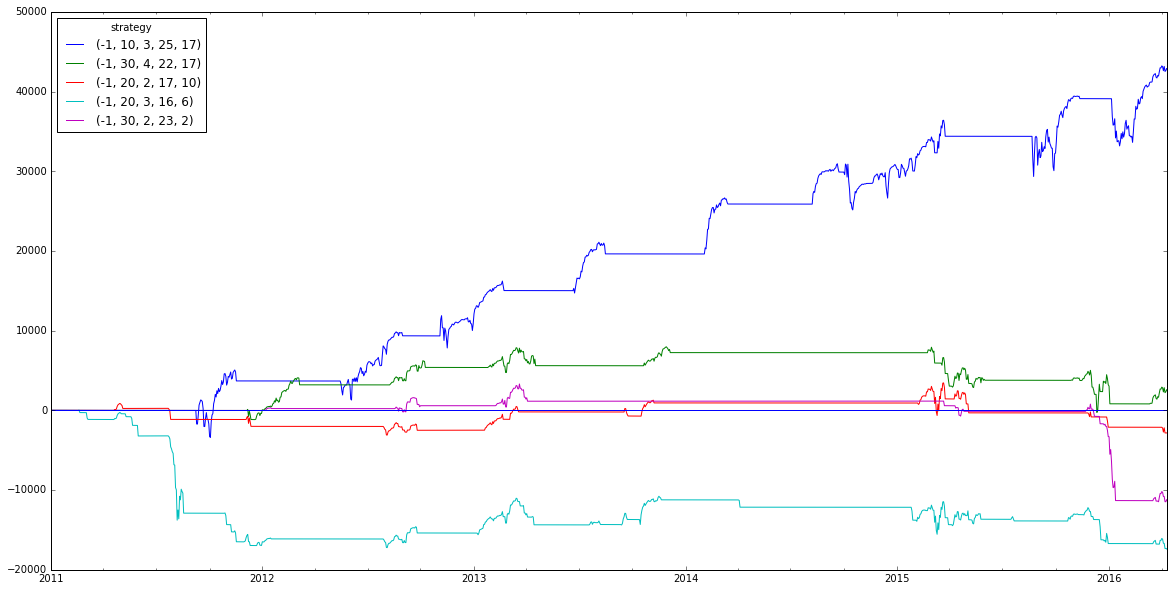

In [24]:
df.plot()
axhline(0)

In [25]:
#stats_df[(stats_df.rebalance_index >= 5) & (stats_df.rebalance_index <= 22)]
stats_df[(stats_df.rebalance_index == 100)]

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
495,False,2012-11-26,2012-11-19,100,-15.0,632.5,1.245293,43.166667,42.166667,80.000000,"(-1, 10, 3, 25, 17)",41.0
496,False,2012-11-26,2012-11-19,100,-759.5,-759.5,-0.500000,0.000001,-1.000000,0.000001,"(-1, 30, 4, 22, 17)",8.0
497,True,2012-11-26,2012-11-19,100,-722.0,-722.0,-0.500000,0.000001,-1.000000,0.000001,"(-1, 20, 2, 17, 10)",8.0
498,True,2012-11-26,2012-11-19,100,-722.0,-722.0,-0.500000,0.000001,-1.000000,0.000001,"(-1, 20, 3, 16, 6)",8.0
499,False,2012-11-26,2012-11-19,100,-1016.5,-888.5,-0.586030,0.125922,-0.874078,20.000000,"(-1, 30, 2, 23, 2)",17.0


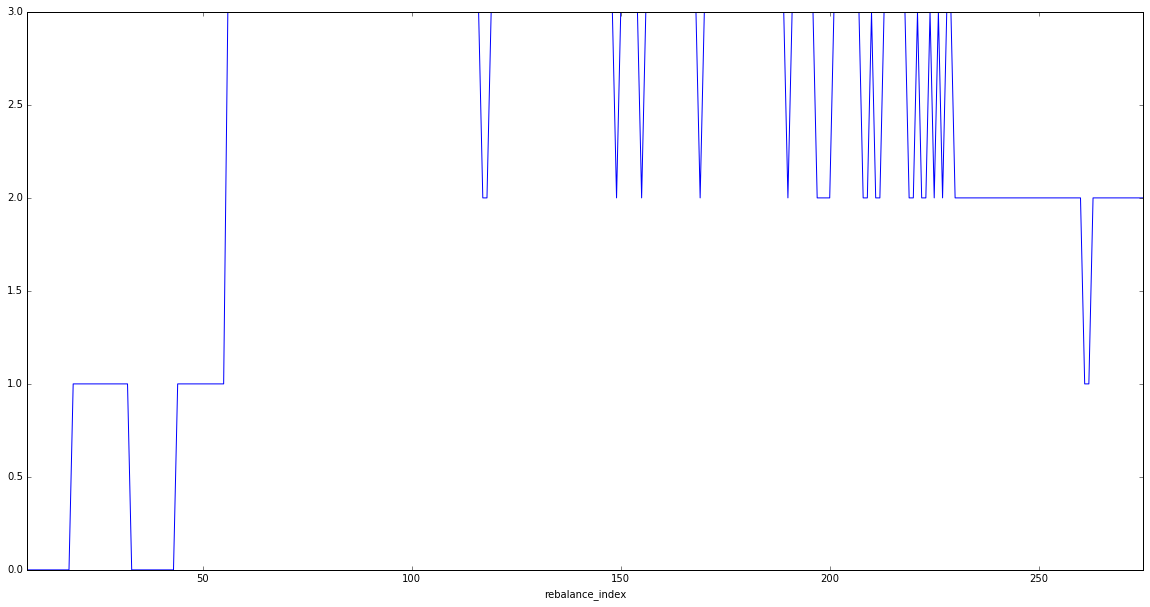

In [26]:
rebalance_history_df.same_strategies.plot()

In [27]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 0].count() / rebalance_history_df.same_strategies.count()

0.082089552238805971

In [28]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 1].count() / rebalance_history_df.same_strategies.count()

0.1044776119402985

In [29]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 2].count() / rebalance_history_df.same_strategies.count()

0.23880597014925373

In [30]:
rebalance_history_df.same_strategies[rebalance_history_df.same_strategies == 3].count() / rebalance_history_df.same_strategies.count()

0.57462686567164178

## Comparing portfolios stats with benchmark(all strategies equity)

In [31]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe 0.0512967678778
Netprofit 44705.0
Max DD -19785.5
Recovery Factor 2.25948295469
Profit factor 1.25280986244
Winrate 33.478531425


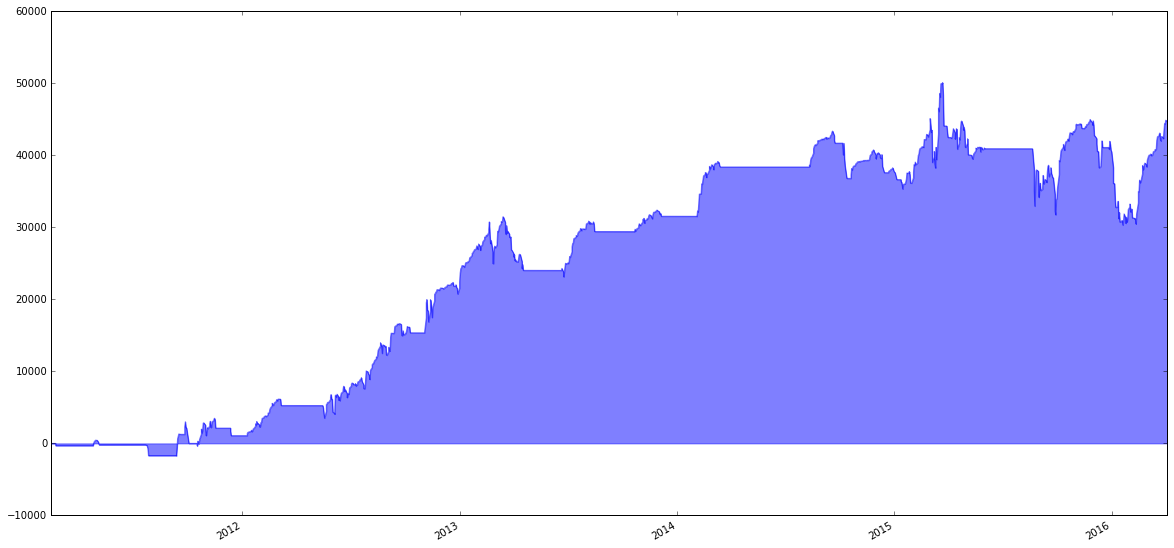

In [32]:
portfolio_stats(best_portfolio, 'Best')

In [ ]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

In [ ]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

In [ ]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

In [ ]:
portfolio_stats(swarm.swarm_picked.sum(axis=1), 'Picked swarm with current approach')

In [ ]:
portfolio_stats(all_equities_sum, 'All equities')

In [ ]:
swarm.swarm.plot(legend=False)